In [3]:
import torch
import torchvision
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from torchvision.models import resnet101, ResNet101_Weights
import cv2

# ResNet-101 + STFT

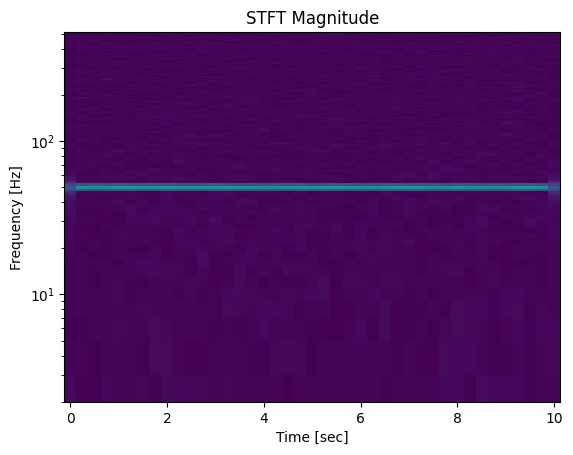

In [6]:
fs = 1024
N = 10*fs
nperseg = 512
amp = 2 * np.sqrt(2)
noise_power = 0.001 * fs / 2
time = np.arange(N) / float(fs)
carrier = amp * np.sin(2*np.pi*50*time)
noise = np.random.normal(scale=np.sqrt(noise_power),
                         size=time.shape)
x = carrier + noise
#Compute and plot the STFT’s magnitude.
#STFTの振幅を計算してプロットします

f, t, Zxx = signal.stft(x, fs=fs, nperseg=nperseg)
plt.figure()
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp)
plt.ylim([f[1], f[-1]])
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
# plt.show()
plt.savefig("./data/img/stft_test.jpg")

In [ ]:
# init model
weights = ResNet101_Weights.IMAGENET1K_V2
model = resnet101(weights=weights)

# set model to evaluation mode
model.eval()
